In [1]:
import pandas as pd
import os
location = str(os.getcwd())

In [2]:
f = (location[:-8] + "Articles\\articles_cleaned.csv")
df = pd.read_csv(f)
df = df.to_dict("index")
print(len(df))

11768


In [3]:
#cleaning body text
for i in range(len(df)):
    df[i]["body"] = str(df[i]["body"]).replace("\n", "").replace("\r", "").replace(".", ". ")
print(len(df))

11768


K MEANS CLUSTERING
https://towardsdatascience.com/generating-colocations-n-grams-6dd8bea31d13
https://towardsdatascience.com/text-clustering-using-k-means-ec19768aae48#:~:text=K%2Dmeans%20clustering%20is%20a,represented%20by%20the%20variable%20K.

In [4]:
import re
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
en_stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
data = []
for i in range(len(df)):
    data.append(df[i]["body"])

In [6]:
def list_tokens(Data):
    """
    This function will convert Articles into list of tokens(either alpha or numeric)
    
    arguments:
        input_text: "Data" of type "pandas Dataframe". 
                    
    return:
        value: "list_of_tokens" after splitting all the articles in 
                "Processed_Content" attribute into list of tokens.
        
    Example:
    Input : This is a nice place to live. 
    Output : ['This', 'is', 'a', 'nice', 'place', 'to', 'live']
    """
    list_of_articles = []
    # For each article in Processed_Content
    for article in Data:
        # split each article into tokens of words either alpha or numeric (not a single punctuation)
        tokens = re.findall("[\w']+", article) # [\w]+ --> Checks for more than one occurrence of words which are either alpha or numeric.
        # Appending each list of tokens for each article.
        list_of_articles.append(tokens)  
    # Unlisting list of list elements to only one list having all the tokens for each & every article.
    list_of_tokens = [item for items in list_of_articles for item in items]
    return list_of_tokens
list_of_tokens = list_tokens(data)
print(len(list_of_tokens))

7804116


In [7]:
def initialize_ngram_finder(list_of_tokens):
    """
    This function will initialize ngram finders for both bigrams & trigrams.
    
    arguments:
        input_text: "list_of_tokens" of type "list" containing all alphanum tokens for each article.
                    
    return:
        value: "bigrams", "trigrams", "bigramFinder", "trigramFinder"
        
    """
    # A number of standard association
    # measures are provided in BigramAssocMeasures and TrigramAssocMeasures.
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    
    # BigramCollocationFinder --> A tool for the finding and ranking of Bigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(list_of_tokens)
    # TrigramCollocationFinder --> A tool for the finding and ranking of trigram collocations or other
    # association measures. It is often useful to use from_words() rather than
    # constructing an instance directly.
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(list_of_tokens)
    return bigrams, trigrams, bigramFinder, trigramFinder
bigrams, trigrams, bigramFinder, trigramFinder = initialize_ngram_finder(list_of_tokens)

In [8]:
def freq_counting_bigram(bigramFinder):
    """
    This function will count how many times adjacent words co-occurs as bigrams.
    
    arguments:
        input_text: "bigramFinder" of type "nltk.collocations.BigramCollocationFinder". 
                    
    return:
        value: "bigramFreqTable" of type "pandas Dataframe" 
                containing bigrams and their corresponding frequencies.
        
    """
    # Generate list of bigrams w.r.t their frequency.
    bigram_freq = bigramFinder.ngram_fd.items()
    # Create Dataframe having bigrams as one column & their corresponding frequency as other column 
    # sorted in descending order of frequency.
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    freq_bi = bigramFreqTable[:100].bigram.values
    return bigramFreqTable, freq_bi

bigramFreqTable, freq_bi = freq_counting_bigram(bigramFinder)
bigramFreqTable.head(10).reset_index(drop=True)
len(bigramFreqTable)

1775136

In [9]:
bigramFreqTable

,bigram,freq
250,"(of, the)",41851
105,"(in, the)",30057
706,"(to, the)",21924
445,"(on, the)",14198
264,"(sexual, assault)",12614
...,...,...
409754,"(distressed, if)",1
409753,"(be, distressed)",1
409746,"(yael3, at)",1
409745,"(at, yael3)",1


In [10]:
#function to filter for ADJ/NN bigrams
def rightTypesBi(ngram):
    """
    This function will filter out all nouns, pronouns, articles that may occur 
    while generating bigrams by checking & setting values to false
    if the pairs in tuple contains any pronouns, articles, etc. 
    
    arguments:
        input_text: "ngram" of type "tuple" of Dataframe.
                    
    return:
        value: True, if tags corresponding to each words in the tuple present in the acceptable_types.
               False, if tags corresponding to each words in the tuple do not present in the acceptable_types or second_type.
               False, if there are pronounce & spaces in passed tuple "ngrams".
               False, if words in passed tuple "ngrams" are StopWords.
        
    """
    
    # If there is pronounce, spaces as word in passed tuple "ngram", return False
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    # For every word in passed tuple "ngram", checks whether that word is present in english stopwords and return False.
    for word in ngram:
        if word in en_stopwords:
            return False
    # tags for adjective, Nouns & their types
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    # Parts of speech tagging corresponding to each word in passed tuple.
    tags = nltk.pos_tag(ngram) #pos_tag() --> is a function of nltk library that is used to tag words 
    # corresponding to their respective parts of speech.
    # Check if the tags corresponding to each words in the tuple are present in "acceptable_types" & "second_type".
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [11]:
#Function for filter bigrams.
def filter_freq_bigrams(bigramFreqTable):
    """
    This function will check for tags of each word present in tuple of the passed Dataframe.
    
    arguments:
        input_text: "bigramFreqTable" of type "pandas Dataframe". 
                    
    return:
        value: "filtered_bi" of type "pandas Dataframe" containing filtered bigrams & their respective frequencies
        & "freq_bi" of type "array" containing only values of bigrams.
        
    """
    # Pass each tuple of Passed Dataframe to function "rightTypesBi()", to filter out those tuples 
    # which do not contain any nouns, pronouns, articles.
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypesBi(x))] 
    # map function is used to map iterable with that of passed function. Iterable is tuple here. function is "rightTypes()"
    # Filtered bigrams
    freq_bi_filter = filtered_bi[:100].bigram.values # Getting top 100 filtered bigrams.
    return filtered_bi, freq_bi_filter

filtered_bi, freq_bi_filter = filter_freq_bigrams(bigramFreqTable)
len(filtered_bi)

485889

In [12]:
filtered_bi

,bigram,freq
264,"(sexual, assault)",12614
30006,"(Title, IX)",3247
8344,"(sexual, misconduct)",3059
6789,"(U, S)",2474
1143,"(sexual, violence)",2431
...,...,...
409739,"(optimist, Lippey)",1
409742,"(Contact, Yael)",1
409743,"(Yael, Lederman)",1
409805,"(single, number)",1


In [31]:
pd.DataFrame(filtered_bi).to_csv('bi-grams.csv')

In [13]:
n_grams = filtered_bi["bigram"]
n_grams_use = []

for item in n_grams:
    n_grams_use.append(item)

In [14]:
len(n_grams_use)

485889

In [17]:
n_grams_to_use = []
for item in n_grams_use:
    n_grams_to_use.append(item[0] + " " + item[1])

In [18]:
def split_nGrams(n_grams_to_use):
    ngrams_splited = [each.split() for each in n_grams_to_use]
    return ngrams_splited

ngrams_splited = split_nGrams(n_grams_to_use)
len(ngrams_splited)
print(n_grams_to_use[0])
print(ngrams_splited[0])

sexual assault
['sexual', 'assault']


Taking n-grams and converting to vectors

In [23]:
import numpy as np

In [ ]:
#  function to read glove vectors from text file
def read_glove(glove_path):
    """
    This function will read glove data from text file and do the following:
    1. prepare dictionary of words and vectors
    2. prepare dictionary of words and index
    3. prepare dictionary of index and words
    """
    # Read word_embedding file stored on glove_path specified.
    with open(glove_path, 'r', encoding='utf-8')as inp_file:
        
        words = set()
        word_to_vec_map = {}
        
        # For every line in embedding file which contains the word & the corresponding vector.
        for line in inp_file:
            # convert each line in embedding file to a list of elements.
            line = line.strip().split()

            # Get first element of the list, i.e., word of each list.
            curr_word = line[0]
            # Add the distinct set of words.
            words.add(curr_word)
            # Create dictionary that will map current word to that of it's vector representation.
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i=1
        words_to_index = {}
        index_to_words = {}
        # For every word in sorted dictionary of words
        for w in sorted(words):
            # map index to each words
            words_to_index[w]=i
            # map words to each index
            index_to_words[i]=w
            i += 1
        
        return words_to_index, index_to_words, word_to_vec_map

In [65]:
def average_word_vectors(list_words, model, vocabulary, num_features):
    """
    This function will take each tokenized sentence having bigrams or trigrams, 
    model = the mapping_of_word_to_vector dictionary, vocabulary = unique set of keys(words) present in model,
    num_features = 50
    
    This function will return the average of feature vector for each word present in list_words.
    """
    # Created array of zeros (type float) of size num_features, i.e., 50.
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    # Put it in try block so that if any exception occur, it will be dealt by below exception block.
#     try:
        # Check if word is in passed list_of_words or not.
    for word in list_words:
        # Check if word is in general vocabulary or not (the unique set of words in word embedding).
        if word in vocabulary:
            # Increment number_of_words
            nwords = nwords + 1
            # add vector array of corresponding key in model which matches the passed word.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        # Take average of feature_vector by dividing with total number of words
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector
    
#     except:
#         # If the exception occurs, while the word isn't found in vocabulary, it will return the array of zeros
#         return np.zeros((num_features,),dtype="float64")
    

    
def averaged_word_vectorizer(corpus, model, num_features):
    """
    This function is taking corpus of bigrams & trigrams, w2v mappings, num of features as a input arguments.
    and returning array of features after taking average using average_word_vectors() function.
    """
    # Get the unique keys out of word_to_vector_map dictionary.
    vocabulary = set(model.keys())
    # Call function average_word_vectors which is returning with averaged vectors for each word in tokenized sentence.
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [40]:
# load glove vectors from pre-trained model domain dataset
glove_path = location + "\domain_embeddings.txt"
new_words_to_index, new_index_to_words, new_word_to_vec_map  = read_glove(glove_path)

In [66]:
w2v_feature_array = averaged_word_vectorizer(corpus=ngrams_splited, model=new_word_to_vec_map,
                                             num_features=300)
w2v_feature_array.shape

(485889, 300)

In [67]:
# Create Dataframe
df = None
df = pd.DataFrame(w2v_feature_array)
df.index = n_grams_to_use
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
sexual assault,-0.190680,0.081750,-0.241839,0.376119,0.133921,-0.336730,-2.51040,0.43751,-0.874235,-0.583520,...,-0.33575,-0.324060,-0.256266,0.049640,-0.336665,0.212866,0.155680,-0.340450,-0.286976,-0.021874
Title IX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sexual misconduct,-0.199300,-0.127725,-0.576860,0.635425,0.245730,-0.205355,-2.27885,0.57876,-0.760600,-0.718755,...,-0.30345,-0.447220,-0.179876,-0.100963,0.046456,0.113137,0.319360,-0.309070,-0.288171,-0.260105
U S,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sexual violence,-0.026115,0.039620,-0.055285,0.529330,0.024445,-0.172530,-3.14895,0.69064,-0.466080,-0.486725,...,-0.25753,-0.209324,-0.023116,-0.335120,-0.079239,-0.085924,0.349745,-0.111275,-0.283656,0.112226


Transforming arrays for better results

In [90]:
#Trying to go back and remove outliers

mean, stdev = np.mean(df, axis = 0), np.std(df, axis = 0)

def fancy (x):
    if x == 0:
        return((np.abs(df[:,0] - mean[0]) > stdev[0]))
    else:
        return((np.abs(df[:,x] - mean[x]) > stdev[x]) * fancy(x-1))

print(len(df.T[fancy(299)]))
print(len(df))

TypeError: '(slice(None, None, None), 299)' is an invalid key

In [69]:
from sklearn import preprocessing
Transposed_Dataset = df.T
Transposed_Dataset.head()
# Used preprocessing module of sklearn library to scale data.
X_scaled = preprocessing.scale(Transposed_Dataset)
len(X_scaled)

300

In [70]:
# I have used StandarScaler() & fit_transform() function of sklearn library to standardize features.
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X_scaled)

In [71]:
df_variance = df.var() # Calculating variance for each feature of dataframe
df_mean = df.stack().mean() # Calculating mean for each feature of dataframe
trans_mean = Transposed_Dataset.stack().mean() # Calculating mean for each feature of transpose
trans_variance = Transposed_Dataset.var() # Calculating variance for each feature of transpose
df_std = df.stack().std()   # Calculating standard deviation for each feature of dataframe
trans_std = Transposed_Dataset.stack().std() # Calculating standard deviation for each feature of transpose

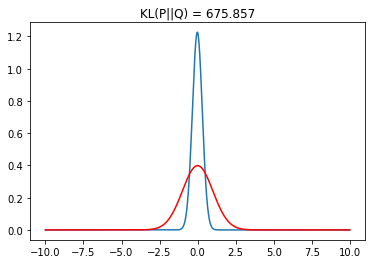

In [72]:
from scipy.stats import norm
import matplotlib.pyplot as plt
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def df_normal_dist():
    x = np.arange(-10, 10, 0.001)
    dp = norm.pdf(x, df_mean, df_std) 
    dq = norm.pdf(x, 0, 1) 
    # Taking KL divergence b/w Dataframe distribution & normal distribution.
    plt.title('KL(P||Q) = %1.3f' % kl_divergence(dp, dq))
    plt.plot(x, dp)
    plt.plot(x, dq, c='red')
df_normal_dist()

Running the K-Means Algorithm

In [73]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [74]:
sklearn_pca = PCA(n_components = 2) # Using PCA to remove cols which has less co-relation
Y_sklearn = sklearn_pca.fit_transform(X_std) #fit_transform() is used to scale training data to learn parameters such as 
# mean & variance of the features of training set and then these parameters are used to scale our testing data.
# As concluded using Elbow Method.
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, max_iter=400, algorithm = 'auto')# Partition 'n' no. of observations into 'k' no. of clusters. 
fitted = kmeans.fit(Y_sklearn) # Fitting k-means model  to feature array
prediction = kmeans.predict(Y_sklearn) # predicting clusters class '0' or '1' corresponding to 'n' no. of observations

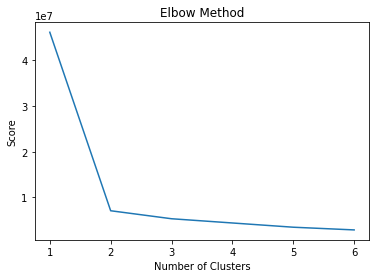

In [75]:
def elbow_method(Y_sklearn):
    """
    This is the function used to get optimal number of clusters in order to feed to the k-means clustering algorithm.
    """

    number_clusters = range(1, 7)  # Range of possible clusters that can be generated
    kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters] # Getting no. of clusters 

    score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))] # Getting score corresponding to each cluster.
    score = [i*-1 for i in score] # Getting list of positive scores.
    
    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()
elbow_method(Y_sklearn)

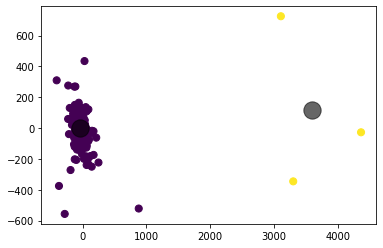

In [76]:
def kmeans_clustering(Y_sklearn, fitted):
    """
    This function will predict clusters on training set and plot the visuals of clusters as well.
    """

    plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis') # Plotting scatter plot 
    centers2 = fitted.cluster_centers_ # It will give best possible coordinates of cluster center after fitting k-means
    plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);
    # As this can be seen from the figure, there is an outlier as well.
kmeans_clustering(Y_sklearn, fitted)

In [78]:
def get_top_features_cluster(X_std, prediction, n_feats):
    # Get unique labels, in this case {0,1}
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # Get indices for each feature corresponding to each cluster.        
        x_means = np.mean(X_std[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = n_grams_to_use
        best_features = [(features[i], x_means[i]) for i in sorted_means] # Retrieve corresponding best features to that of best scores.
        Df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(Df) # append both the Dataframes to a list
    return dfs
dfs = get_top_features_cluster(X_std, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

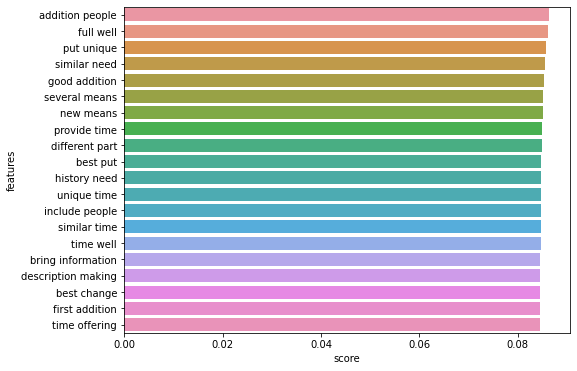

In [81]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[:25][0]) # Get top 25 rows of 1st Dataframe

<AxesSubplot:xlabel='score', ylabel='features'>

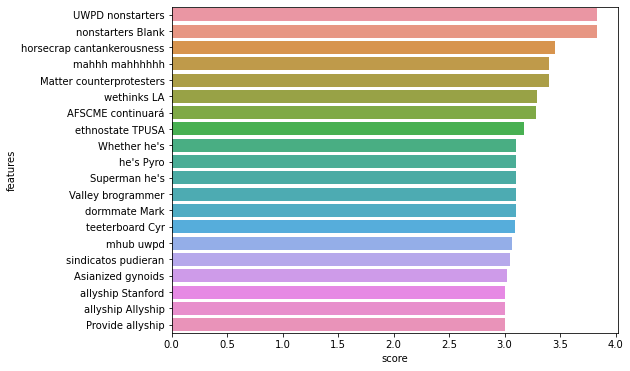

In [82]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[:25][1])